## 삼성전자 주가 데이터 로드

In [2]:
!pip install Finance-datareader
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 3.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.1-py3-none-any.whl size=28985 sha256=183dffe05c7d7ab13e3a17ba4389463bbcb6da847cf7d5e82796741399e86b4e
  Stored in directory: /root/.cache/pip/wheels/bc/2a/c2/a56e77d07edc16a1fa7fb012667e55cb0643cfa65996bddecc
Successfully built ta


### 라이브러리

In [3]:
!pip install Finance-datareader
!pip install ta
!pip install pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

import ta
import FinanceDataReader as fdr

import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

from pandas_datareader import data as pdr

import datetime

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [5]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [6]:
# s: 삼성전자에 대한 데이터프레임
s = fdr.DataReader('005930', '2015-01-01')
s.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2015-01-02,26799,26799,26540,26600,175499,0.002261
2015-01-05,26720,26720,26260,26660,202790,0.002256
2015-01-06,26300,26340,25760,25900,304710,-0.028507
2015-01-07,25880,26220,25640,26140,286455,0.009266
2015-01-08,26780,26780,26199,26280,289552,0.005356


### data plot

            Close
Date             
2015-01-02  26600
2015-01-05  26660
2015-01-06  25900
2015-01-07  26140
2015-01-08  26280
...           ...
2022-06-02  66700
2022-06-03  66800
2022-06-07  65500
2022-06-08  65300
2022-06-09  65200

[1829 rows x 1 columns]


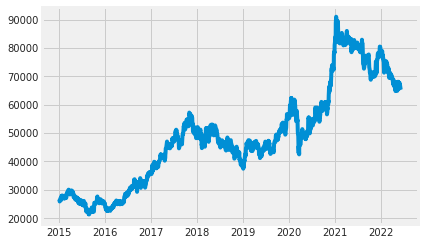

In [7]:
X = s.iloc[:, :4]
y = s.iloc[:, 3:4]
print(y)

plt.plot(y, label = 'samsung')
plt.show()

In [8]:
"""
학습이 잘되기 위해 데이터 정규화 
StandardScaler	각 특징의 평균을 0, 분산을 1이 되도록 변경
MinMaxScaler	최대/최소값이 각각 1, 0이 되도록 변경
"""

from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

# Train Data
X_train = X_ss[:1500, :]
X_test = X_ss[1500:, :]

# Test Data 
"""
( 굳이 없어도 된다. 하지만 얼마나 예측데이터와 실제 데이터의 정확도를 확인하기 위해 
from sklearn.metrics import accuracy_score 를 통해 정확한 값으로 확인할 수 있다. )
"""
y_train = y_mm[:1500, :]
y_test = y_mm[1500:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (1500, 4) (1500, 1)
Testing Shape (329, 4) (329, 1)


In [9]:
"""
torch Variable에는 3개의 형태가 있다. 
data, grad, grad_fn 한 번 구글에 찾아서 공부해보길 바랍니다. 
"""
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([1500, 1, 4]) torch.Size([1500, 1])
Testing Shape torch.Size([329, 1, 4]) torch.Size([329, 1])


In [10]:
# GPU 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # device
print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [11]:
# 모델 만들기

class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) #lstm
    self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
    self.fc = nn.Linear(128, num_classes) #fully connected last layer

    self.relu = nn.ReLU() 

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through LSTM

    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
   
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = self.relu(hn)
    out = self.fc_1(out) #first Dense
    out = self.relu(out) #relu
    out = self.fc(out) #Final Output
   
    return out 

In [12]:
# 네트워크 파라미터 구성하기

num_epochs = 30000 #1000 epochs
learning_rate = 0.00001 #0.001 lr

input_size = 4 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  # adam optimizer

In [13]:
# 학습하기

for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final.to(device)) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = loss_function(outputs, y_train_tensors.to(device))

  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.25948
Epoch: 100, loss: 0.23249
Epoch: 200, loss: 0.20808
Epoch: 300, loss: 0.18606
Epoch: 400, loss: 0.16627
Epoch: 500, loss: 0.14853
Epoch: 600, loss: 0.13268
Epoch: 700, loss: 0.11858
Epoch: 800, loss: 0.10608
Epoch: 900, loss: 0.09507
Epoch: 1000, loss: 0.08540
Epoch: 1100, loss: 0.07696
Epoch: 1200, loss: 0.06965
Epoch: 1300, loss: 0.06334
Epoch: 1400, loss: 0.05794
Epoch: 1500, loss: 0.05335
Epoch: 1600, loss: 0.04948
Epoch: 1700, loss: 0.04622
Epoch: 1800, loss: 0.04351
Epoch: 1900, loss: 0.04125
Epoch: 2000, loss: 0.03937
Epoch: 2100, loss: 0.03779
Epoch: 2200, loss: 0.03646
Epoch: 2300, loss: 0.03532
Epoch: 2400, loss: 0.03434
Epoch: 2500, loss: 0.03347
Epoch: 2600, loss: 0.03269
Epoch: 2700, loss: 0.03196
Epoch: 2800, loss: 0.03128
Epoch: 2900, loss: 0.03062
Epoch: 3000, loss: 0.02997
Epoch: 3100, loss: 0.02932
Epoch: 3200, loss: 0.02867
Epoch: 3300, loss: 0.02801
Epoch: 3400, loss: 0.02733
Epoch: 3500, loss: 0.02663
Epoch: 3600, loss: 0.02589
Epoch: 3700, 

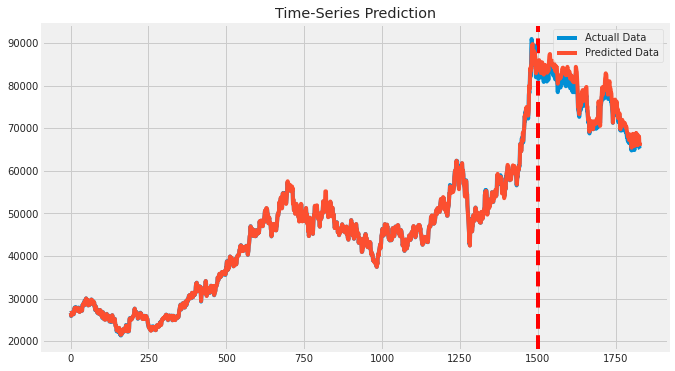

In [14]:
df_X_ss = ss.transform(s.iloc[:, :4])
df_y_mm = mm.transform(s.iloc[:, 3:4])

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))
train_predict = lstm1(df_X_ss.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=1500, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

### 이제 lstm 모델 성능평가(예: MSE) 등등 만들면 됩니다

In [ ]:
# 실제값, 예측값 flatten 하기

pre_data = list(data_predict[1500:].flatten())

n_s = np.array(s.iloc[:,3:4])           
true_data = list(n_s[1500:].flatten())

In [1]:
from sklearn.metrics import mean_squared_error

In [60]:
score_table = pd.DataFrame({'True': true_data,
                            'Pred': pre_data})

In [61]:
score_table

,True,Pred
0,83000,85055.390625
1,82700,84171.250000
2,81600,83921.148438
3,84200,85777.242188
4,84900,86027.562500
...,...,...
324,66700,67639.468750
325,66800,67996.273438
326,65500,66271.257812
327,65300,66391.085938


In [62]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)

score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [63]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 2499540.8889661515, RMSE : 1580.993639761448, SCORE : 99.956827345804


In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
#plt.xlim(70)
plt.legend()

실제값 - 예측값 제곱 / 실제값 제곱

오차제곱 / 실제제곱

